# scan, pymc3 and theano

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(context="paper" , style ="whitegrid",rc={"figure.facecolor":"white"})

import statsmodels.api as sm
import pymc3 as pm
import theano
import theano.tensor as tt
import pickle
import datetime

import warnings
warnings.filterwarnings('ignore')

In [30]:
x = tt.dvector('x')
def step(idx, array):
    return array[idx] + idx
results, updates = theano.scan(fn=step,
                               sequences=tt.arange(x.shape[0]),
                               non_sequences=[x])
f = theano.function([x], results)
f([1., 0., 2.13])

array([1.  , 1.  , 4.13])

In [31]:
x1 = [1,2,3]
x2 = [5,6,7]
# beta = [3,5]
y = [28,36]
ind= [0,2]
index = np.array([0,2])
x1T = tt.as_tensor_variable(x1)
x2T = tt.as_tensor_variable(x2)
yT = tt.as_tensor_variable(y)
indT = tt.as_tensor_variable(ind)


# sampling parameters 
nIter = 1000
nBurn = 500
chains = 2
cores = 2
randomSeed = 1123890

def logp(beta,x1,x2,y,ind):
    print(ind)
    x1N = x1[index]
    x2N = x2[index]
    def MSE(i,l,xx1,xx2,yy,beta):
        print(i)
        print(l)
        print(x2)
        e = (beta[0]*xx1 + beta[1]*xx2 - yy )*(beta[0]*xx1 + beta[1]*xx2 - y,2 )
        return(e)
    #s_y = MSE(0,beta,x1,x2,y,ind)
    s_y = theano.scan(fn =MSE,
                      sequences=[tt.arange(2),ind,x1N,x2N,y],
                      non_sequences=[beta]
                     )
    return(s_y)

In [32]:
with pm.Model() as model:
    beta= pm.Normal('beta', mu=0, sigma=100,shape=2)
    pm.DensityDist('likelihood',logp,  observed=dict(beta=beta,x1=x1T,x2=x2T,y=yT,ind=indT)) 
    # fit the model
    trace = pm.sample(draws=nIter,
                      tune=nBurn, 
                      chains=chains,
                      cores=cores,
                      target_accept=0.8,
                      random_seed=randomSeed)


Elemwise{Cast{float64}}.0
<TensorType(int64, scalar)>
<TensorType(float64, scalar)>
Elemwise{Cast{float64}}.0


TypeError: can't multiply sequence by non-int of type 'TensorVariable'

In [24]:
alpha = 0.95
dfSum = pm.summary(trace,credible_interval=alpha,stat_funcs={"median":np.median}).round(3)
dfSum

,mean,sd,hpd_2.5%,hpd_97.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat,median
beta[0],-0.699,0.126,-0.825,-0.573,0.089,0.075,2.0,2.0,2.0,13.0,3.01,-0.699
beta[1],-126.006,35.551,-191.835,-69.336,22.613,18.525,2.0,2.0,3.0,11.0,2.06,-127.077


# Class inset 

In [187]:
class LogLike(tt.Op):
    itypes = [tt.dvector] # expects a vector of parameter values when called
    otypes = [tt.dscalar] # outputs a single scalar value (the log likelihood)

    def __init__(self,x1,x2,y,ind):
        self.x1 = x1
        self.x2 = x2 
        self.y = y 
        self.ind = ind
        
    def logp(self,beta):
        x1N = tt.as_tensor_variable(self.x1[self.ind])
        x2N = tt.as_tensor_variable(self.x2[self.ind])
        y = tt.as_tensor_variable(self.y)
        
        def MSE(xx1,xx2,yy,beta):
            e = -tt.power(beta[0]*xx1 + beta[1]*xx2 - yy ,2)
            e = tt.sum(e)
            return(e)
        
        #s_y = MSE(x1N,x2N,y,beta)
        
        def MSEScan(xx1,xx2,yy,beta):
            e = -tt.power(beta[0]*xx1 + beta[1]*xx2 - yy,2)
            return(e)
        
        s_y,_ = theano.scan(fn =MSEScan,
                  sequences=[x1N,x2N,y],
                  non_sequences=[beta]
                 )
        s_y = tt.sum(s_y)
        return(s_y  )

    def perform(self, node, inputs, outputs):
        beta  = inputs # this will contain my variables
        logl = self.logp(beta)
        outputs[0][0] = np.array(logl) # output the log-likelihood

In [188]:
x1 = np.array([1,2,3])
x2 = np.array([5,6,7])
beta = [3,5]
y = np.array([28,44])
ind= np.array([0,2])

# create our Op
nIter = 500

In [189]:
with pm.Model() as model:
    beta= pm.Normal('beta', mu=0, sigma=100,shape=2)
    logp = LogLike(x1,x2,y,ind).logp(beta) 
    pm.Potential("likelihood",logp)
    # fit the model
    trace = pm.sample(draws=nIter)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:05<00:00, 396.13draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


In [190]:
alpha = 0.95
dfSum = pm.summary(trace,credible_interval=alpha,stat_funcs={"median":np.median}).round(3)
dfSum

,mean,sd,hpd_2.5%,hpd_97.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat,median
beta[0],3.112,0.758,1.721,4.672,0.066,0.048,132.0,125.0,135.0,290.0,1.0,3.109
beta[1],4.964,0.283,4.408,5.504,0.025,0.018,129.0,129.0,129.0,238.0,1.0,4.957


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c20cec898>,
      dtype=object)

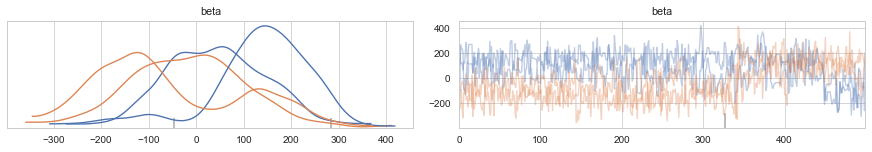

In [171]:
pm.traceplot(trace,var_names="beta")

#  testing speed

In [8]:
import timeit

In [28]:
k = 20
result = 1
A = 2
start = timeit.default_timer()
for i in range(k):
    result = result * A
print(result)

stop = timeit.default_timer()
print('Time: ', stop - start)  

1048576
Time:  0.00020187700010865228


In [14]:

k = tt.iscalar("k")
A = tt.vector("A")
# Symbolic description of the result
result, updates = theano.scan(fn=lambda prior_result, A: prior_result * A,
                              outputs_info=tt.ones_like(A),
                              non_sequences=A,
                              n_steps=k)
final_result = result[-1]
power = theano.function(inputs=[A,k], outputs=final_result, updates=updates)


In [29]:
start = timeit.default_timer()
print(power([2],20))
stop = timeit.default_timer()
print('Time: ', stop - start)  

[1048576.]
Time:  0.000941656999884799
